<a href="https://colab.research.google.com/github/saicham/Study/blob/main/2024_SeoulICT_CNN_DogCat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 공통함수

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
# 데이터 분리를 위한 함수

from sklearn.model_selection import train_test_split

import numpy as np
# 데이터 분석
import pandas as pd


# Pandas option 정의
pd.set_option( 'display.max_columns', 20 )
pd.set_option( 'display.max_colwidth', 20 )
pd.set_option( 'display.unicode.east_asian_width', True )

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter note상에 그래프 결과 포함 매직 명령
%matplotlib inline

# Matplotlib 기본 글꼴 정의
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# matplotlib 한글 출력을 위해 폰트 설치
import sys

#노트북이 코랩에서 실행 중인지 체크합니다.
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections

# 나눔 폰트를 설치합니다.
!sudo apt-get -qq -y install fonts-nanum

import matplotlib.font_manager as fm
font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

for fpath in font_files:
    fm.fontManager.addfont(fpath)

#     # 나눔바른고딕 폰트로 설정합니다.
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

# 마이너스 기호 표시 오류 수정
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

# 경고 문제 출력 제한
import warnings
warnings.filterwarnings( 'ignore' )

# 훈련 결과 확인 함수
def disp_training( history ):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range( 1, len( accuracy ) + 1 )


    plt.title( '훈련 및 검증 정확도' )
    plt.plot( epochs, history.history[ 'accuracy' ], label = 'accuracy' )
    plt.plot( epochs, history.history[ 'val_accuracy' ], label = 'val_accuracy' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Epochs' )


    plt.figure()
    plt.title( '훈련 및 검증 오차' )
    plt.plot( epochs, history.history[ 'loss' ], label = 'loss' )
    plt.plot( epochs, history.history[ 'val_loss' ], label = 'val_loss' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Epochs' )
    plt.show()

def disp_loss( history ):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range( 1, len( loss ) + 1 )
    plt.title( '훈련 및 검증 오차' )
    plt.plot( epochs, history.history[ 'loss' ], label = 'loss' )
    plt.plot( epochs, history.history[ 'val_loss' ], label = 'val_loss' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Epochs' )
    plt.show()



## 구글드라이브에 공유된 파일 다운로드

In [1]:
import gdown

In [2]:
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd',output='dogs-vs-cats.zip')

Downloading...
From (original): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
From (redirected): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd&confirm=t&uuid=c30f411b-fc5a-4354-a275-53cfbffce43b
To: /content/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:46<00:00, 18.2MB/s]


'dogs-vs-cats.zip'

In [4]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [6]:
import cv2
import glob
import os

In [7]:
img_list = glob.glob('train/*.jpg')

In [9]:
len(img_list)

25000

## train폴더의 데이터를 훈련/검증/테스트 폴더를 생성하여 복사

In [11]:
import os, shutil, pathlib

In [16]:
original_path = pathlib.Path('/content/train')
new_base_path = pathlib.Path('/content/cats_vs_dogs_small')

In [17]:
def make_subset(subset_name, start_idx, end_idx):
  for category in ('cat','dog'):  # 레이블로 사용
    dir = new_base_path / subset_name /category  # 새로운 데이터 저장 디렉토리 일름
    os.makedirs(dir) # 디렉토리 생성
    fnames = [f'{category}.{i}.jpg' for i in range(start_idx, end_idx)] # 복사할 파일 목록 생성
    for fname in fnames:
      shutil.copyfile(src=original_path / fname, dst = dir/fname)  # 파일 복사

In [19]:
# train
make_subset(subset_name ='train', start_idx = 0, end_idx= 1000)
# valid
make_subset(subset_name ='validation', start_idx = 1000, end_idx= 1500)
# test
make_subset(subset_name ='test', start_idx = 1500, end_idx= 2500)

In [20]:
from tensorflow.keras.utils import image_dataset_from_directory

## 훈련/검증/테스트 데이터셋 변수 생성

In [21]:
# train폴더 밑에 dog, cat폴더가 레이블이 되고
train_dataset = image_dataset_from_directory(
    new_base_path / 'train',  # 시작 폴더
    image_size = (180,180),  # 이미지 사이즈를 모두 동일크기로 조정
    batch_size = 32  # 하나의 배치마다 32개 파일로 설정
)
validation_dataset = image_dataset_from_directory(
    new_base_path / 'validation',
    image_size = (180,180),
    batch_size = 32
)
test_dataset = image_dataset_from_directory(
    new_base_path / 'test',
    image_size = (180,180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [23]:
train_dataset.class_names

['cat', 'dog']

In [27]:
for data_batch, label_batch in train_dataset:
    print(f'data batch shape: {data_batch.shape}')
    print(f'label batch shape: {label_batch.shape}')
    break

data batch shape: (32, 180, 180, 3)
label batch shape: (32,)


## CNN모델 구조 작성

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Rescaling
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

In [31]:
model = Sequential()
model.add(Input(shape=(180,180,3)))
model.add(Rescaling(1./255)) # image scale 변환하여 정규화

# 이미지 특성 추출 - 필터크기를 증가시켜 이미지를 세분화하여 특성을 추출
model.add(Conv2D(32,3, activation='relu'))  # 필터, 커널, 활성화함수
model.add(MaxPooling2D(2))
model.add(Conv2D(64,3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(128,3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(256,3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(256,3, activation='relu'))

# 이미지 분류
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

## 모델 컴파일 및 학습

In [32]:
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [34]:
# val_loss값이 최적의 파라미터를 저장
callbacks = [ModelCheckpoint(filepath='/content/dogs-vs-cats-cnn.keras',
                             save_best_only=True,
                             monitor='val_loss')]

In [37]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data = validation_dataset,
                    callbacks= callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.5165 - loss: 0.7017 - val_accuracy: 0.5120 - val_loss: 0.6908
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5410 - loss: 0.6867 - val_accuracy: 0.6120 - val_loss: 0.6483
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6024 - loss: 0.6622 - val_accuracy: 0.6450 - val_loss: 0.6147
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6834 - loss: 0.6156 - val_accuracy: 0.6820 - val_loss: 0.5875
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6929 - loss: 0.5783 - val_accuracy: 0.6880 - val_loss: 0.5872
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.7214 - loss: 0.5556 - val_accuracy: 0.6910 - val_loss: 0.5890
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7564 - loss: 0.5022 - val_accuracy: 0.7120 - val_loss: 0.5885
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.7739 - loss: 0.4655 - val_accuracy: 0.7310

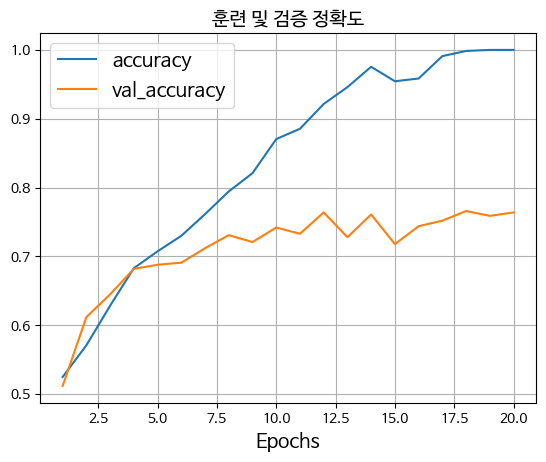

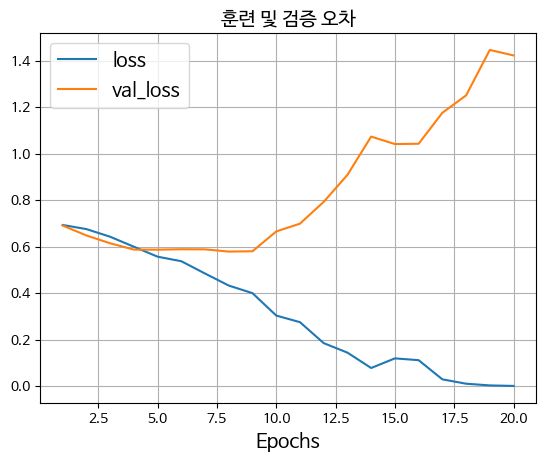

In [39]:
disp_training( history)

## 모델평가


In [40]:
from tensorflow.keras.models import load_model

In [43]:
# val_loss값이 최적의 파라미터를 저장한 모델로 테스트 검증
test_model = load_model('/content/dogs-vs-cats-cnn.keras')
loss, accuracy = test_model.evaluate(test_dataset)

print(f'test loss : {loss}')
print(f'test accuracy : {accuracy}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.7339 - loss: 0.5950
test loss : 0.5914309620857239
test accuracy : 0.7360000014305115


## 데이터 증강레이어 생성

In [46]:
from tensorflow.keras.layers import RandomZoom, RandomRotation,RandomFlip

In [47]:
data_augmentation = Sequential([RandomFlip('horizontal'),
                                RandomRotation(0.1),
                                RandomZoom(0.2)])

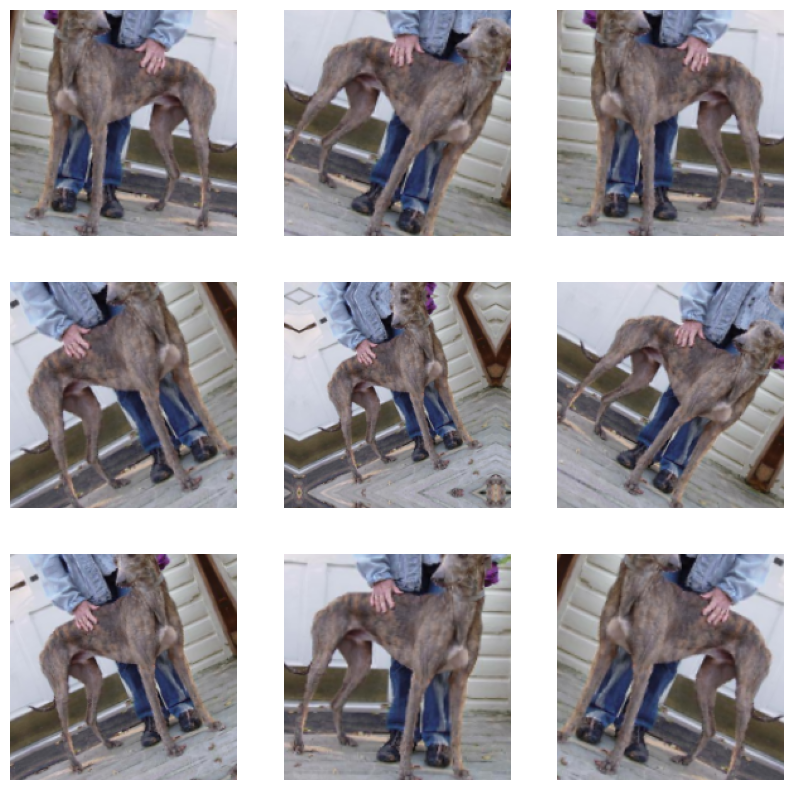

In [52]:
plt.figure(figsize=(10,10))
for images,_ in train_dataset.take(1):  #train_dataset의 하나의 배치사이즈 32개를 가져옴
  for i in range(9):
    augmentation_images = data_augmentation(images)
    ax = plt.subplot(3,3, i+1)

    plt.imshow(augmentation_images[0].numpy().astype('uint8'))
    plt.axis('off')

## 기존 모델에 데이터증강레이어 추가

In [54]:
from tensorflow.keras.models import Sequential, Model

In [55]:
inputs = Input(shape=(180,180,3))
x = data_augmentation(inputs)  # 데이터 증강
x = Rescaling(1./255)(x)


# 이미지 특성 추출 - 필터크기를 증가시켜 이미지를 세분화하여 특성을 추출
x = Conv2D(32,3, activation='relu')(x)  # 필터, 커널, 활성화함수
x = MaxPooling2D(2)(x)
x = Conv2D(64,3, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(128,3, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(256,3, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(256,3, activation='relu')(x)

# 이미지 분류
x = Flatten()(x)
x = Dropout(0.5)(x)  # dropout 적용하여 일반화성능을 개선
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

## 모델 재컴파일 및 학습

In [56]:
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
# val_loss값이 최적의 파라미터를 저장
callbacks = [ModelCheckpoint(filepath='/content/dogs-vs-cats-cnn.keras',
                             save_best_only=True,
                             monitor='val_loss')]

In [60]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data = validation_dataset,
                    callbacks= callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7296 - loss: 0.5622 - val_accuracy: 0.6790 - val_loss: 0.5939
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.7226 - loss: 0.5571 - val_accuracy: 0.7160 - val_loss: 0.5466
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.7498 - loss: 0.5286 - val_accuracy: 0.7060 - val_loss: 0.5640
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.7393 - loss: 0.5297 - val_accuracy: 0.7460 - val_loss: 0.5168
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.7685 - loss: 0.5058 - val_accuracy: 0.7300 - val_loss: 0.5251
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7369 - loss: 0.5269 - val_accuracy: 0.7070 - val_loss: 0.5730
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7497 - loss: 0.4953 - val_accuracy: 0.7620 - val_loss: 0.4855
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7716 - loss: 0.4957 - val_accuracy: 0.

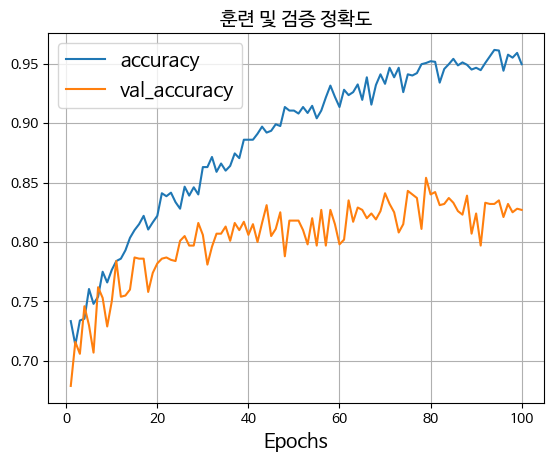

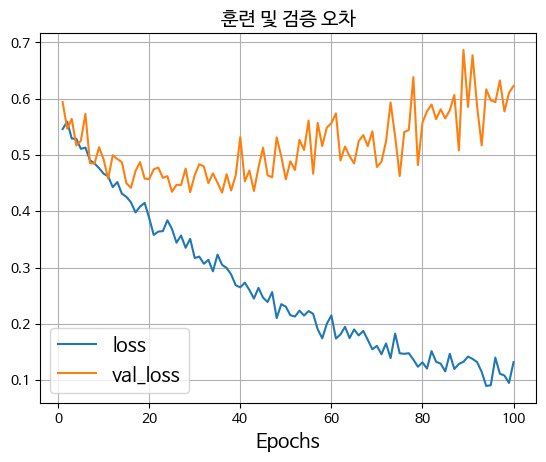

In [61]:
disp_training( history)

## 모델평가 - 일반화 성능이 향상되어 성능이 개선됨

In [62]:
# val_loss값이 최적의 파라미터를 저장한 모델로 테스트 검증
test_model = load_model('/content/dogs-vs-cats-cnn.keras')
loss, accuracy = test_model.evaluate(test_dataset)

print(f'test loss : {loss}')
print(f'test accuracy : {accuracy}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7922 - loss: 0.4483
test loss : 0.462994784116745
test accuracy : 0.7914999723434448
